In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import torch.nn.functional as F

In [2]:
# Agent hyperparameters
buffer_size = int(1e5)
batch_size = 64
LR = 5e-4
TAU = 1e-3
gamma = 0.99
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:

# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self):
        experiences = random.sample(self.buffer, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

# Define the Rainbow DQN Agent
class RainbowAgent:
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.memory = ReplayBuffer(buffer_size, batch_size)
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, gamma)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# Define the Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [4]:
# Problem variables
ROAD_COUNTS = 4
CHANGE_SIZE = 10
MAX_STATE_VALUE = 200

In [5]:
# Training Loop
n_episodes = 1000
max_steps = 1000

In [6]:
from environment import TrafficLightEnv

# Instantiate the Environment
env = TrafficLightEnv(roads_count=ROAD_COUNTS, change_size=CHANGE_SIZE, max_value=MAX_STATE_VALUE)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Instantiate the Agent
agent = RainbowAgent(state_size, action_size, seed=0)

total_reward = []

# Episodes
for i_episode in range(1, n_episodes+1):
    state = env.reset()
    episode_reward = []

    # Iterations
    for t in range(max_steps):
        # Select an action
        eps = max(eps_end, eps_start*eps_decay**i_episode)
        action = agent.act(state, eps)
        
        # Take action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)
        
        # Store experience and train the agent
        agent.step(state, action, reward, next_state, done)
        
        state = next_state

        # Track scores
        episode_reward.append(reward)

        if done:
            break
    
    total_reward.append(episode_reward)
    print("Episode {} Score: {}".format(i_episode, np.sum(episode_reward)))

    # Perform any necessary logging or evaluation

env.close()


Episode 1 Score: -15.993124999999997
Episode 2 Score: -18.718125
Episode 3 Score: -22.01125
Episode 4 Score: -16.795624999999998
Episode 5 Score: -19.499687500000004
Episode 6 Score: -17.632187500000004
Episode 7 Score: -11.458437500000002
Episode 8 Score: -15.185
Episode 9 Score: -22.283750000000005
Episode 10 Score: -22.7175
Episode 11 Score: -24.198124999999994
Episode 12 Score: -19.339687500000004
Episode 13 Score: -16.375625
Episode 14 Score: -9.9825
Episode 15 Score: -19.269687500000003
Episode 16 Score: -22.5828125
Episode 17 Score: -11.7125
Episode 18 Score: -20.120312499999997
Episode 19 Score: -14.34625
Episode 20 Score: -18.571875
Episode 21 Score: -20.37625
Episode 22 Score: -17.95625
Episode 23 Score: -22.281250000000004
Episode 24 Score: -13.523124999999999
Episode 25 Score: -14.90125
Episode 26 Score: -17.900625000000005
Episode 27 Score: -12.889687499999999
Episode 28 Score: -16.402187499999997
Episode 29 Score: -12.085937500000002
Episode 30 Score: -12.648125000000002


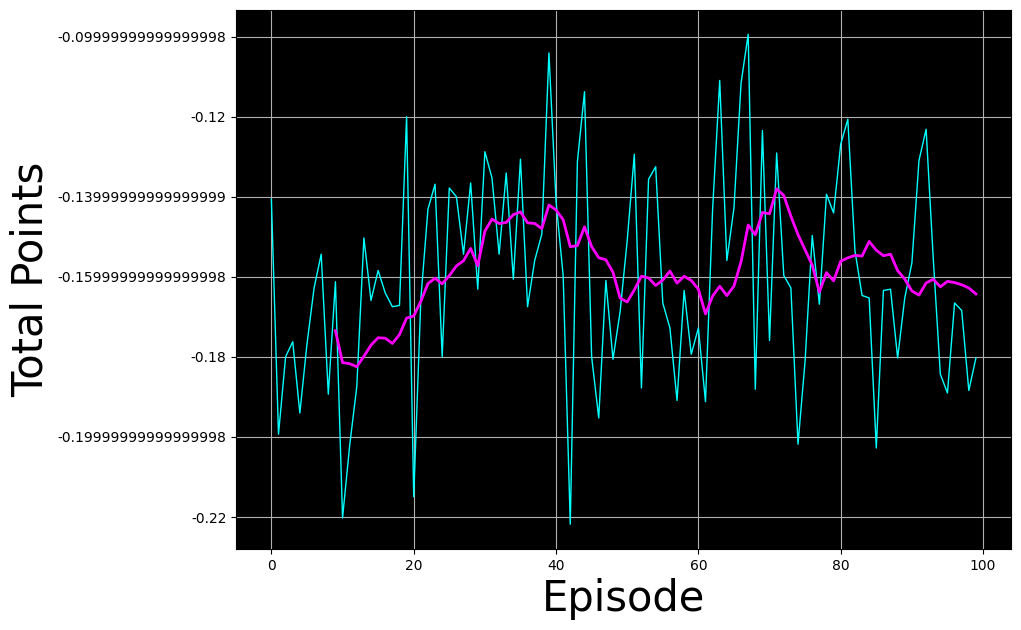

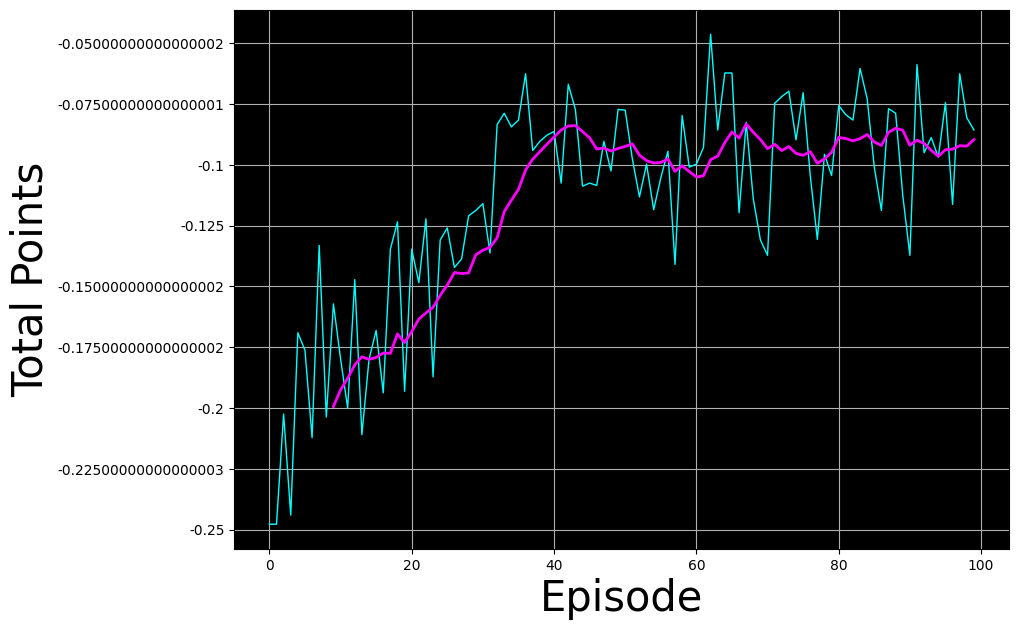

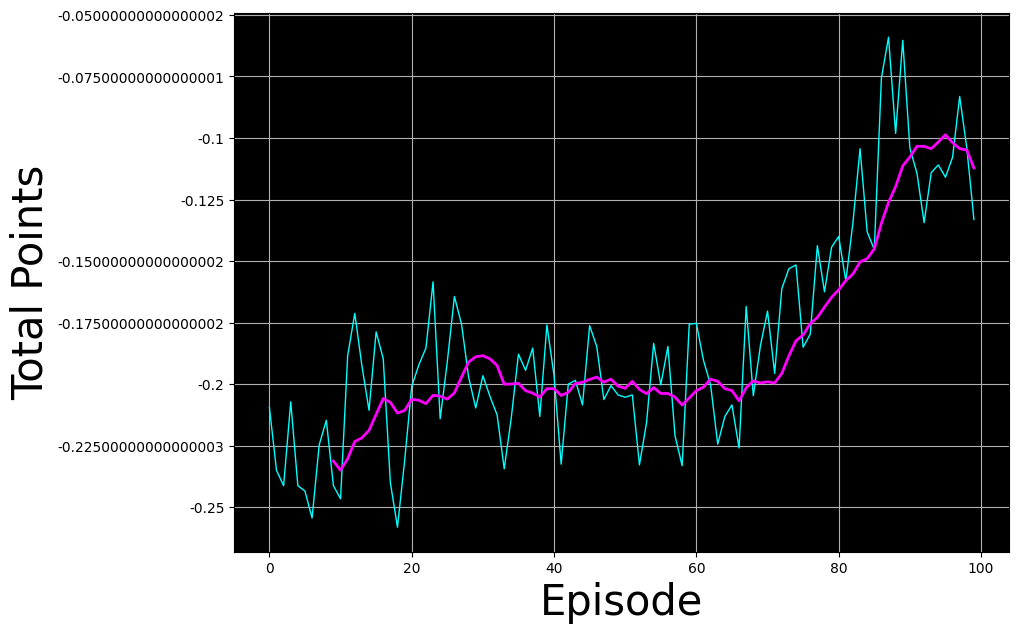

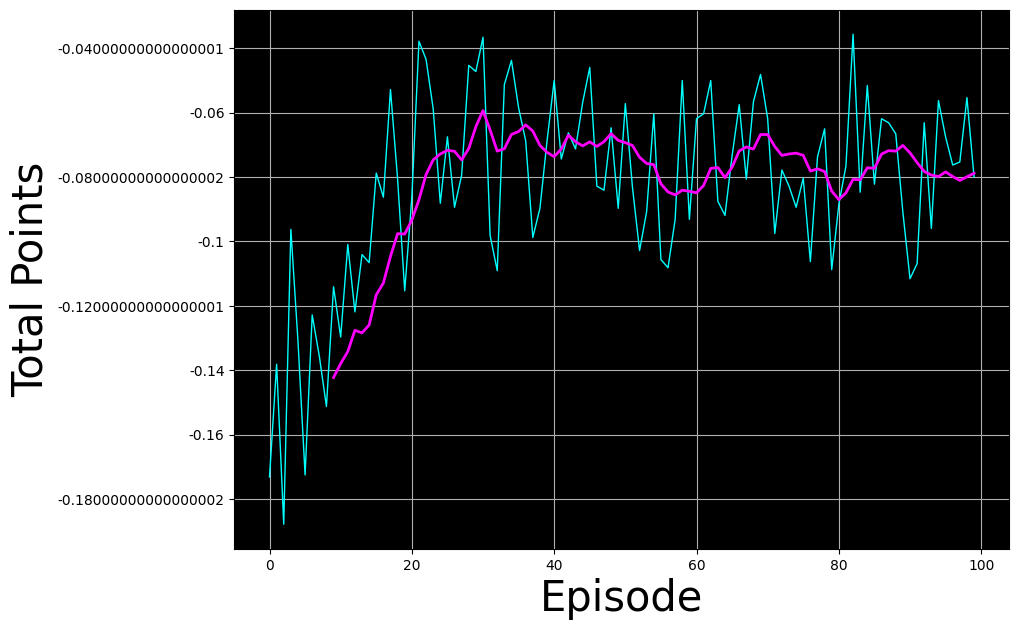

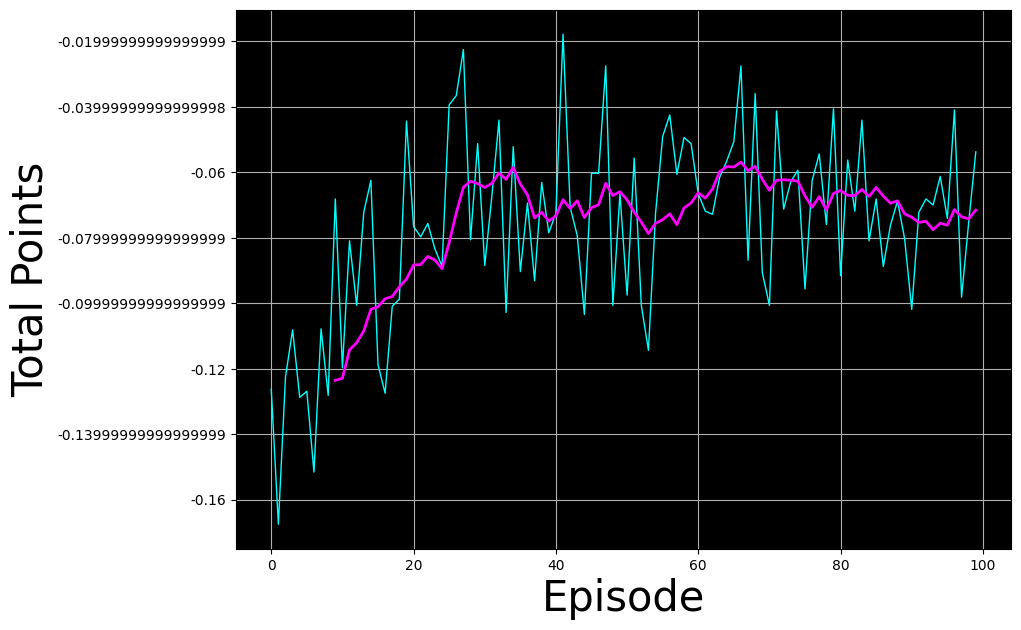

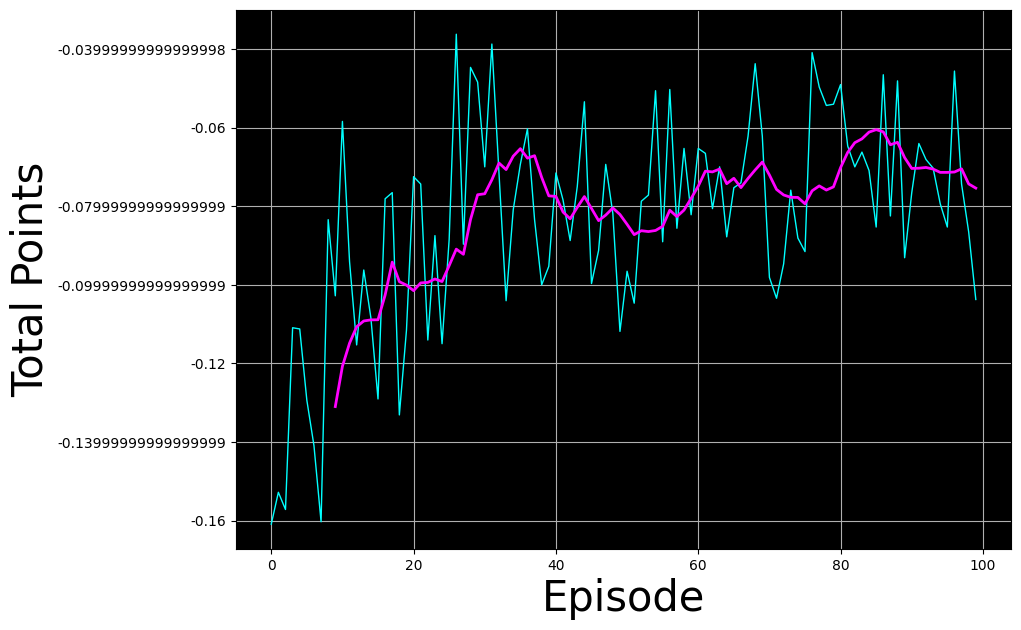

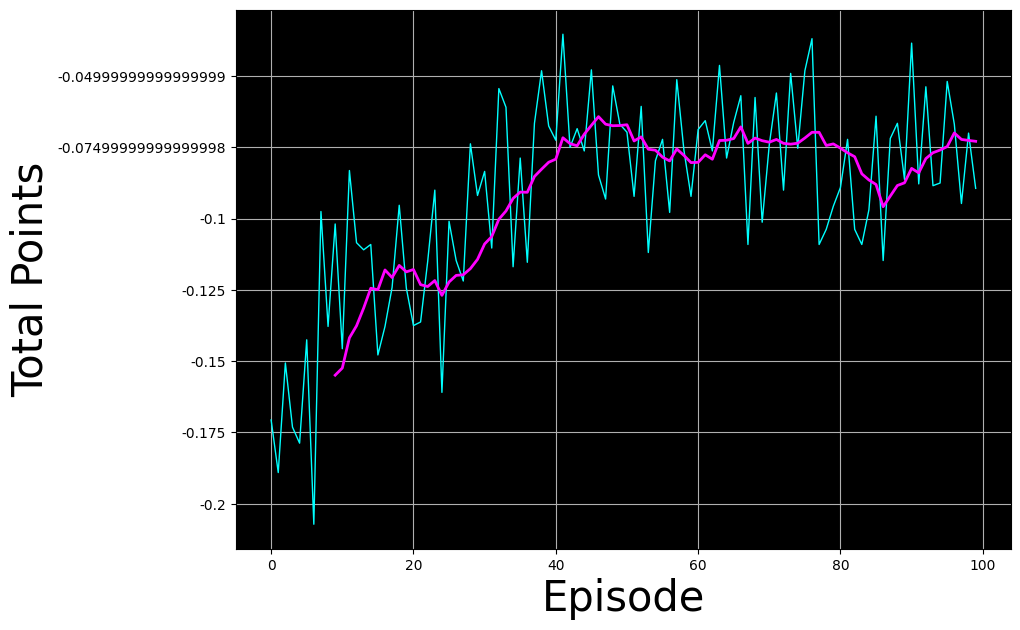

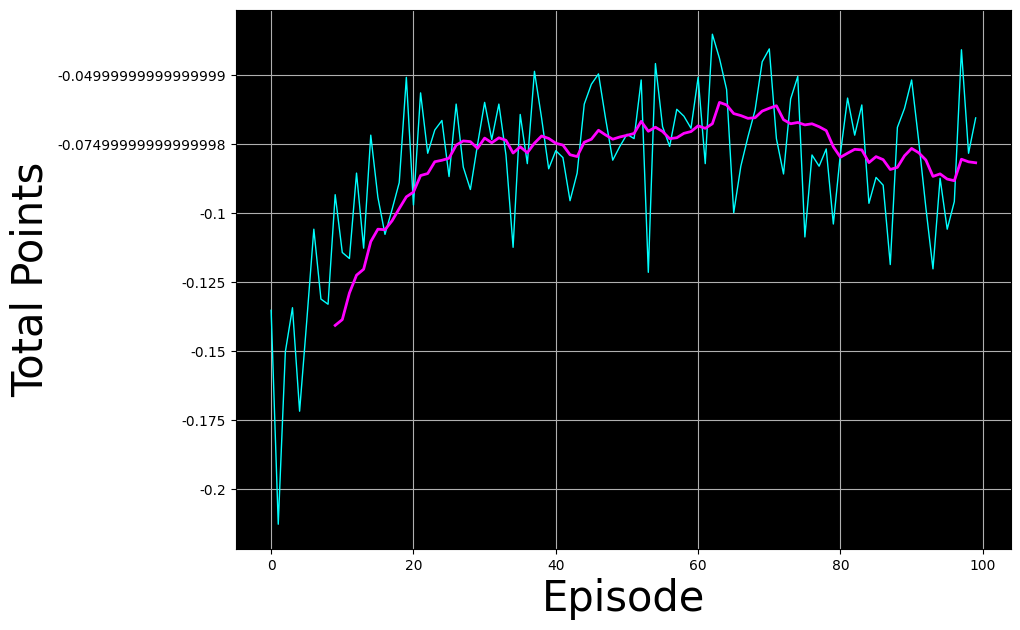

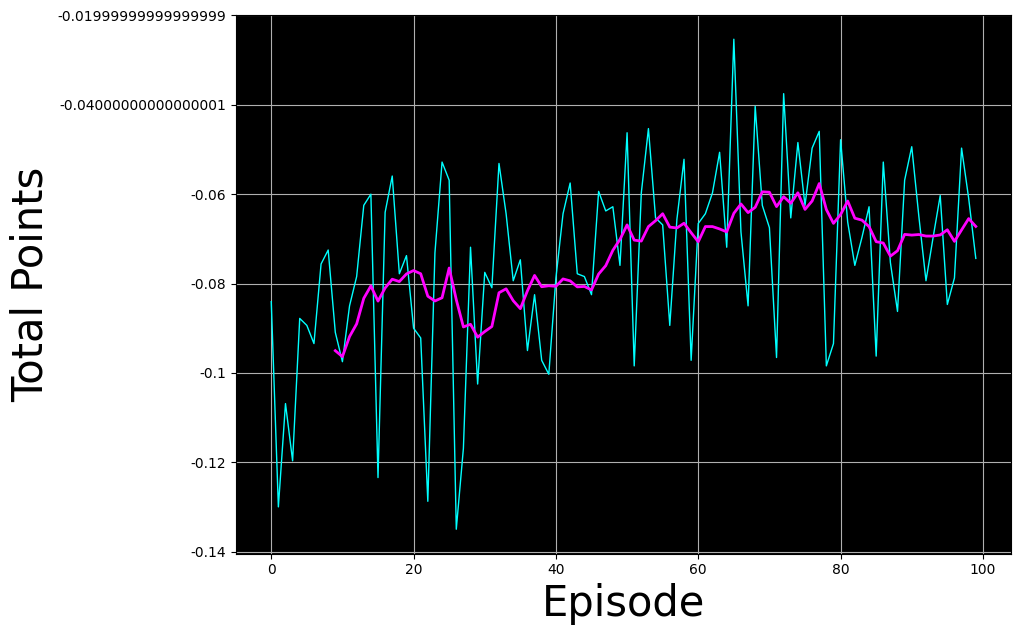

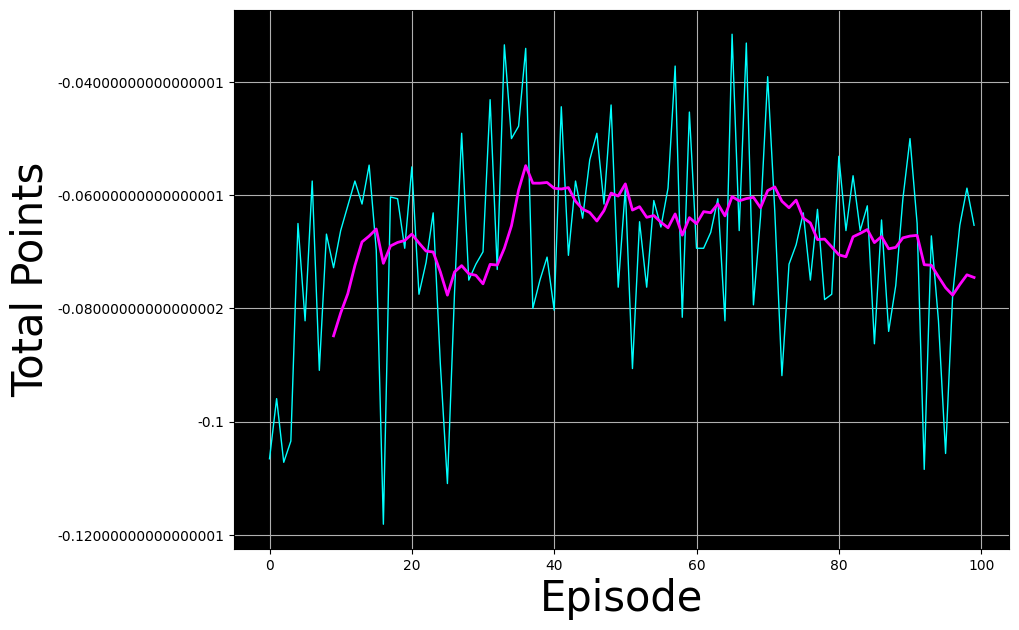

In [8]:
from utils import plot_history

for episode in range(0, n_episodes, n_episodes//10):
    plot_history(total_reward[episode])

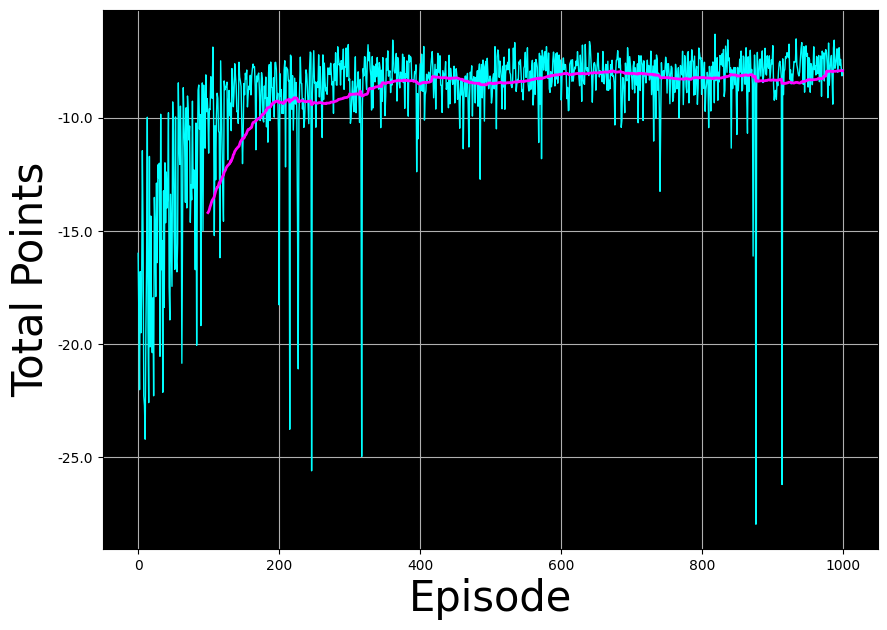

In [9]:
plot_history(np.sum(total_reward, axis=1))

In [10]:
state = env.reset()
done = False
test_reward = []
while not done:
    env.render()
    state = env.state
    action = agent.act(state)
    print('action taken:', env.cast_action(action))
    print('reward:', reward)
    state, reward, done, _ = env.step(action)
    test_reward.append(reward)
    print('')
env.render()

green light timer [ 23. 137.  39.  90.]
avg waiting times (-) [266. 152. 250. 199.]
vehicles counts (-) [ 61. 111.  51.  62.]
in counts (+) [129. 184.  21.  87.]
action taken: [1 1 1 1 2]
reward: -0.073125

green light timer [ 33. 147.  49. 100.]
avg waiting times (-) [296. 182. 280. 229.]
vehicles counts (-) [134. 114.  45. 197.]
in counts (+) [ 33. 111.  49.  62.]
action taken: [2 1 1 1 1]
reward: -0.10375

green light timer [ 43. 147.  49. 100.]
avg waiting times (-) [296. 192. 290. 239.]
vehicles counts (-) [102. 110. 154. 197.]
in counts (+) [ 43. 114.  45. 100.]
action taken: [2 1 1 1 1]
reward: -0.1353125

green light timer [ 53. 147.  49. 100.]
avg waiting times (-) [296. 202. 300. 249.]
vehicles counts (-) [148.  38. 135. 176.]
in counts (+) [ 53. 110.  49. 100.]
action taken: [2 1 1 1 1]
reward: -0.15125

green light timer [ 63. 147.  49. 100.]
avg waiting times (-) [296. 212. 310. 259.]
vehicles counts (-) [130. 125. 191. 121.]
in counts (+) [ 63.  38.  49. 100.]
action take

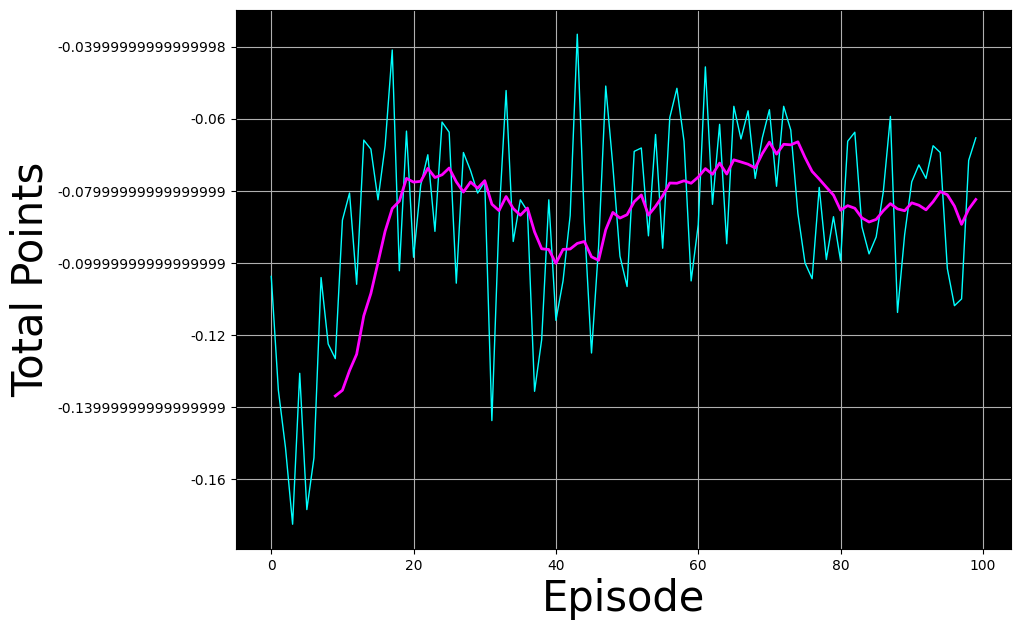

In [11]:
plot_history(test_reward)